# Facial-Emotion-Recogntion-HCL

## Environment

### System

- Os: Windows 11 64bit
- Python: 3.11.9

### Package

- pytorch: cu126 
- ipykernel: 6.29.5
- pandas: 2.2.2
- Pillow: 10.3.0
- tqdm: 4.66.4
- opencv-python: 4.11.0
- albumentations: 2.06

### Import libraries

In [ ]:
!sudo apt-get install -y libgl1 libglib2.0-0
!pip uninstall torch torchvision -y
!pip install -r requirements/requirements-normal.txt
!pip install -r requirements/requirements-pytorch.txt

In [1]:
import warnings
import pandas as pd

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [2]:
import scripts.augment as sa
import scripts.preprocessing as sp
import scripts.evaluate as ev
import scripts.model as md
import scripts.backbone as b

2025-05-26 00:35:04.522954: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 00:35:04.537075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748219704.556084   23177 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748219704.561909   23177 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 00:35:04.580353: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Define constant

In [3]:
# === Define paths ===
affectnet_raw_path = "./data/affectnet/" 
processed_root_path = "./data/processed/"  
processed_metadata_csv = "./data/processed/train.csv"  
augmented_root_path = "./data/augmented/"  
augmented_metadata_csv = "./data/augmented/train.csv"  

# === Define preprocessing & augmentation parameters ===
img_size = (224, 224)   
rename_images = True   
dry_run = False       
augment_target_per_class = 8000    
augment_severity = "medium"        

In [4]:
import torch
import gc 

model_configs = [
    ("facebook/deit-small-distilled-patch16-224", 20, 0.5),
    # ("facebook/deit-base-distilled-patch16-224", 20, 0.6),
    # ("microsoft/resnet-50", 5),
    # ("microsoft/resnet-152", 5),
    # ("google/vit-base-patch16-224", 5),
    # ("timm/vit_small_patch16_224.augreg_in21k", 5),
]

# Load data once
data_loaders = ev.load_affectnet_data(augmented_metadata_csv)
train_loader = data_loaders['train_loader']
val_loader = data_loaders['val_loader']
test_loader = data_loaders['test_loader']

[✓] Train: 44800 | Val: 9600 | Test: 9600


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot(metrics, model, model_name):
    report_dict = metris["classification_report"]       # dict 结构
    cm          = np.asarray(metris["confusion_matrix"]) # shape = (C, C)
    
    target_names = list(report_dict.keys())[:-3]   # 最后三个是 micro / macro / weighted
    num_classes  = len(target_names)
    
    # precision / recall / f1
    metrics_df = pd.DataFrame(report_dict).T.loc[target_names,
                                                 ["precision", "recall", "f1-score"]]
    
    # 计算 specificity (= TN / (TN + FP)) 按列算
    specificities = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificities.append(tn / (tn + fp))
    metrics_df["specificity"] = specificities
    
    # ---------------------------------------------
    # 2️⃣ 绘制按类别对比柱状图
    # ---------------------------------------------
    plt.figure(figsize=(12, 6))
    metrics_df.plot(kind="bar", rot=0, figsize=(12, 6))
    plt.ylim(0, 1.05)
    plt.title(f"{model_name} Per-class comparison of Precision / Recall / F1 / Specificity")
    plt.ylabel("Score")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
    
    # ---------------------------------------------
    # 3️⃣ 计算并绘制 ROC 曲线（OvR，一条线/类别 + micro / macro）
    # ---------------------------------------------
    # 3-1 准备标签与概率
    X_test, y_test = model.feature_extractor.extract_features(test_loader)
    y_score = model.classifier.predict_proba(X_test)
    
    # 转成 one-hot
    y_test_bin = label_binarize(y_test, classes=range(num_classes))
    
    # 3-2 逐类别 ROC
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # 3-3 micro / macro 平均
    fpr["micro"], tpr["micro"], _ = roc_curve(
        y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # macro 需要对所有 fpr 取并集并插值
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # 3-4 画图
    plt.figure(figsize=(8, 7))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f"micro-avg ROC (AUC = {roc_auc['micro']:.2f})", linestyle="--")
    plt.plot(fpr["macro"], tpr["macro"],
             label=f"macro-avg ROC (AUC = {roc_auc['macro']:.2f})", linestyle="--")
    
    for i, cls in enumerate(target_names):
        plt.plot(fpr[i], tpr[i],
                 label=f"{cls} (AUC = {roc_auc[i]:.2f})")
    
    plt.plot([0, 1], [0, 1], linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curves")
    plt.legend(loc="lower right", ncol=2, fontsize=8)
    plt.tight_layout()
    plt.show()

[✓] Train: 44800 | Val: 9600 | Test: 9600

=== Training pipeline for facebook/deit-small-distilled-patch16-224 ===
[INFO] Loading classification and base vision models: facebook/deit-small-distilled-patch16-224 on cuda


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-small-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-small-distilled-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning facebook/deit-small-distilled-patch16-224...
[INFO] Fine-tuning 10,649,864/21,669,512 params (49.15%)


Epoch 1/20: 100%|██████████| 700/700 [04:18<00:00,  2.71it/s]


Epoch 1: Train 1.6271, Val 1.3860, Acc 0.4796


Epoch 2/20: 100%|██████████| 700/700 [04:19<00:00,  2.69it/s]


Epoch 2: Train 1.3225, Val 1.2553, Acc 0.5307


Epoch 3/20: 100%|██████████| 700/700 [04:20<00:00,  2.69it/s]


Epoch 3: Train 1.2189, Val 1.2171, Acc 0.5404


Epoch 4/20: 100%|██████████| 700/700 [04:20<00:00,  2.69it/s]


Epoch 4: Train 1.1384, Val 1.1619, Acc 0.5734


Epoch 5/20: 100%|██████████| 700/700 [04:20<00:00,  2.69it/s]


Epoch 5: Train 1.0675, Val 1.1285, Acc 0.5823


Epoch 6/20: 100%|██████████| 700/700 [04:20<00:00,  2.69it/s]


Epoch 6: Train 0.9965, Val 1.0936, Acc 0.5982


Epoch 7/20: 100%|██████████| 700/700 [04:20<00:00,  2.69it/s]


Epoch 7: Train 0.9352, Val 1.0687, Acc 0.6101


Epoch 8/20: 100%|██████████| 700/700 [04:20<00:00,  2.69it/s]


Epoch 8: Train 0.8795, Val 1.0529, Acc 0.6214


Epoch 9/20: 100%|██████████| 700/700 [04:20<00:00,  2.68it/s]


Epoch 9: Train 0.8245, Val 1.0299, Acc 0.6338


Epoch 10/20: 100%|██████████| 700/700 [04:20<00:00,  2.68it/s]


Epoch 10: Train 0.7726, Val 1.0180, Acc 0.6401


Epoch 11/20: 100%|██████████| 700/700 [04:21<00:00,  2.68it/s]


Epoch 11: Train 0.7344, Val 1.0093, Acc 0.6484


Epoch 12/20: 100%|██████████| 700/700 [04:21<00:00,  2.68it/s]


Epoch 12: Train 0.6960, Val 0.9934, Acc 0.6569


Epoch 13/20: 100%|██████████| 700/700 [04:21<00:00,  2.68it/s]


Epoch 13: Train 0.6623, Val 0.9859, Acc 0.6608


Epoch 14/20: 100%|██████████| 700/700 [04:20<00:00,  2.68it/s]


Epoch 14: Train 0.6364, Val 0.9830, Acc 0.6640


Epoch 15/20: 100%|██████████| 700/700 [04:20<00:00,  2.68it/s]


Epoch 15: Train 0.6179, Val 0.9808, Acc 0.6667


Epoch 16/20: 100%|██████████| 700/700 [04:21<00:00,  2.68it/s]


Epoch 16: Train 0.5965, Val 0.9761, Acc 0.6721


Epoch 17/20: 100%|██████████| 700/700 [04:20<00:00,  2.68it/s]


Epoch 17: Train 0.5841, Val 0.9744, Acc 0.6722


Epoch 18/20: 100%|██████████| 700/700 [04:21<00:00,  2.68it/s]


Epoch 18: Train 0.5890, Val 0.9731, Acc 0.6720


Epoch 19/20: 100%|██████████| 700/700 [04:20<00:00,  2.68it/s]


Epoch 19: Train 0.5763, Val 0.9733, Acc 0.6727


Epoch 20/20: 100%|██████████| 700/700 [04:21<00:00,  2.68it/s]


Epoch 20: Train 0.5775, Val 0.9729, Acc 0.6729
Training hybrid model for facebook/deit-small-distilled-patch16-224...
[INFO] Extracting features for train set
[INFO] Extracting features for val set
[INFO] Training LightGBM classifier with 44800 samples
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	train's multi_logloss: 0.574594	valid's multi_logloss: 1.04263
[INFO] Training completed in 41.52 seconds
Evaluating hybrid model for facebook/deit-small-distilled-patch16-224...
[INFO] Extracting test features


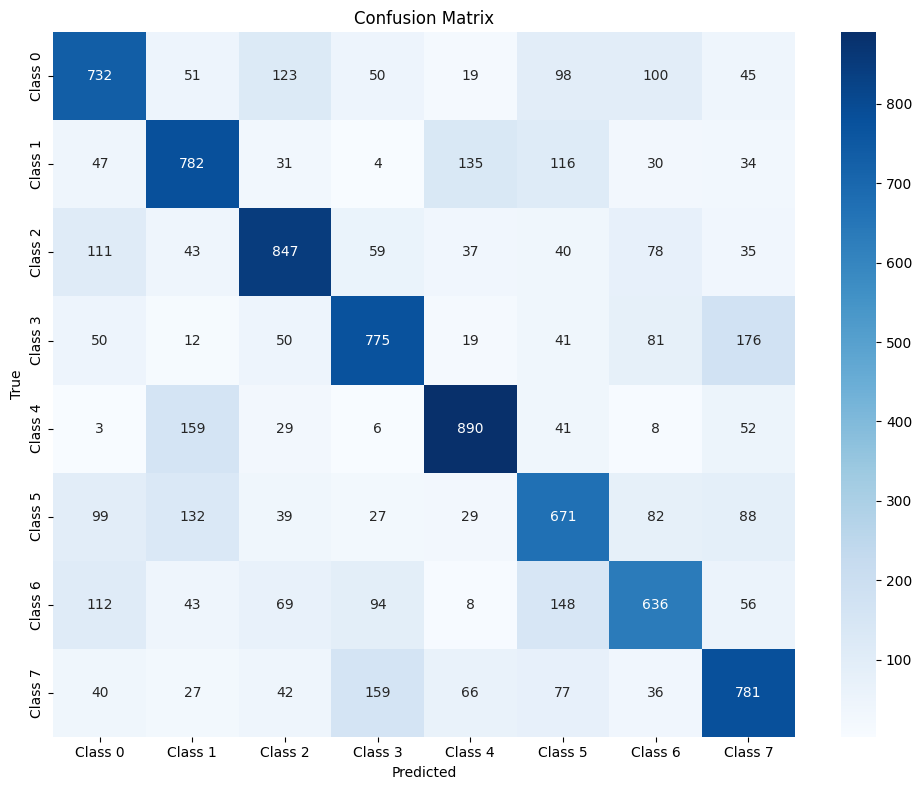

[INFO] Fine-tuned model saved to models/facebook_deit-small-distilled-patch16-224/deit_model
[INFO] Model saved to models/facebook_deit-small-distilled-patch16-224
Saved model to models/facebook_deit-small-distilled-patch16-224
All models trained and saved successfully.


In [7]:
# Iterate and train each backbone + hybrid classifier
for model_name, epochs, freeze_ratio in model_configs:
    print(f"\n=== Training pipeline for {model_name} ===")
    # 1. Instantiate and fine-tune backbone
    backbone = b.VisionFeatureExtractor(model_name=model_name, freeze_ratio=freeze_ratio)
    print(f"Fine-tuning {model_name}...")
    
    backbone.finetune(
        train_loader,
        val_loader,
        num_classes=8,
        epochs=epochs,
        learning_rate=2e-5,
        weight_decay=0.01
    )

    # Clear unused memory to prevent OOM
    del backbone.classification_model
    torch.cuda.empty_cache()
    gc.collect()

    # 2. Train hybrid classifier
    classifier = md.LightGBMClassifier()
    hybrid_model = md.HybridEmotionClassifier(backbone, classifier)
    print(f"Training hybrid model for {model_name}...")
    hybrid_model.train(train_loader, val_loader)

    # 3. Evaluate on test set
    print(f"Evaluating hybrid model for {model_name}...")
    hybrid_model.evaluate(test_loader)

    # 4. Save and cleanup
    save_path = f"models/{model_name.replace('/', '_')}"
    hybrid_model.save(save_path)
    print(f"Saved model to {save_path}")

    # Cleanup GPU memory
    del backbone
    del hybrid_model
    torch.cuda.empty_cache()
    gc.collect()

print("All models trained and saved successfully.")

[✓] Train: 44800 | Val: 9600 | Test: 9600

=== Training pipeline for facebook/deit-base-distilled-patch16-224 ===
[INFO] Loading classification and base vision models: facebook/deit-base-distilled-patch16-224 on cuda


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning facebook/deit-base-distilled-patch16-224...
[INFO] Fine-tuning 28,357,640/85,806,344 params (33.05%)


Epoch 1/20: 100%|██████████| 700/700 [11:33<00:00,  1.01it/s]


Epoch 1: Train 1.5442, Val 1.3103, Acc 0.5111


Epoch 2/20: 100%|██████████| 700/700 [11:35<00:00,  1.01it/s]


Epoch 2: Train 1.2490, Val 1.1987, Acc 0.5541


Epoch 3/20: 100%|██████████| 700/700 [11:36<00:00,  1.01it/s]


Epoch 3: Train 1.1299, Val 1.1600, Acc 0.5690


Epoch 4/20: 100%|██████████| 700/700 [11:36<00:00,  1.00it/s]


Epoch 4: Train 1.0366, Val 1.0907, Acc 0.5956


Epoch 5/20: 100%|██████████| 700/700 [11:36<00:00,  1.00it/s]


Epoch 5: Train 0.9447, Val 1.0306, Acc 0.6274


Epoch 6/20: 100%|██████████| 700/700 [11:36<00:00,  1.00it/s]


Epoch 6: Train 0.8635, Val 1.0062, Acc 0.6417


Epoch 7/20: 100%|██████████| 700/700 [11:37<00:00,  1.00it/s]


Epoch 7: Train 0.7906, Val 0.9764, Acc 0.6554


Epoch 8/20: 100%|██████████| 700/700 [11:37<00:00,  1.00it/s]


Epoch 8: Train 0.7158, Val 0.9521, Acc 0.6729


Epoch 9/20: 100%|██████████| 700/700 [11:37<00:00,  1.00it/s]


Epoch 9: Train 0.6514, Val 0.9241, Acc 0.6867


Epoch 10/20: 100%|██████████| 700/700 [11:37<00:00,  1.00it/s]


Epoch 10: Train 0.5957, Val 0.9234, Acc 0.6911


Epoch 11/20: 100%|██████████| 700/700 [11:36<00:00,  1.00it/s]


Epoch 11: Train 0.5480, Val 0.9088, Acc 0.7024


Epoch 12/20: 100%|██████████| 700/700 [11:37<00:00,  1.00it/s]


Epoch 12: Train 0.5136, Val 0.8921, Acc 0.7101


Epoch 13/20: 100%|██████████| 700/700 [11:37<00:00,  1.00it/s]


Epoch 13: Train 0.4739, Val 0.8927, Acc 0.7117


Epoch 14/20: 100%|██████████| 700/700 [11:38<00:00,  1.00it/s]


Epoch 14: Train 0.4475, Val 0.8852, Acc 0.7169


Epoch 15/20: 100%|██████████| 700/700 [11:38<00:00,  1.00it/s]


Epoch 15: Train 0.4235, Val 0.8826, Acc 0.7180


Epoch 16/20: 100%|██████████| 700/700 [11:39<00:00,  1.00it/s]


Epoch 16: Train 0.4150, Val 0.8833, Acc 0.7222


Epoch 17/20: 100%|██████████| 700/700 [11:39<00:00,  1.00it/s]


Epoch 17: Train 0.4010, Val 0.8779, Acc 0.7246


Epoch 18/20: 100%|██████████| 700/700 [11:39<00:00,  1.00it/s]


Epoch 18: Train 0.3964, Val 0.8789, Acc 0.7249


Epoch 19/20: 100%|██████████| 700/700 [11:39<00:00,  1.00it/s]


Epoch 19: Train 0.3892, Val 0.8780, Acc 0.7260


Epoch 20/20: 100%|██████████| 700/700 [11:39<00:00,  1.00it/s]


Epoch 20: Train 0.3885, Val 0.8779, Acc 0.7247
Training hybrid model for facebook/deit-base-distilled-patch16-224...
[INFO] Extracting features for train set
[INFO] Extracting features for val set
[INFO] Training LightGBM classifier with 44800 samples
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	train's multi_logloss: 0.395872	valid's multi_logloss: 0.94224
[INFO] Training completed in 81.22 seconds
Evaluating hybrid model for facebook/deit-base-distilled-patch16-224...
[INFO] Extracting test features


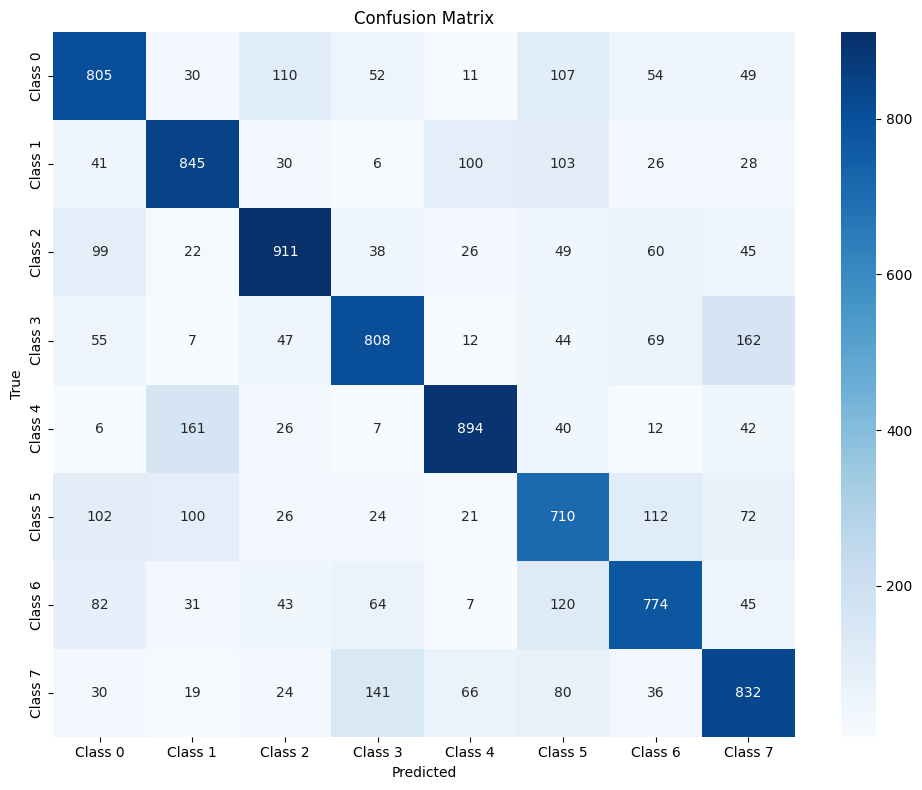

[INFO] Fine-tuned model saved to models/facebook_deit-base-distilled-patch16-224/deit_model
[INFO] Model saved to models/facebook_deit-base-distilled-patch16-224
Saved model to models/facebook_deit-base-distilled-patch16-224
All models trained and saved successfully.


In [4]:
import torch
import gc 

model_configs = [
    # ("facebook/deit-small-distilled-patch16-224", 20, 0.5),
    ("facebook/deit-base-distilled-patch16-224", 20, 0.6),
    # ("microsoft/resnet-50", 5),
    # ("microsoft/resnet-152", 5),
    # ("google/vit-base-patch16-224", 5),
    # ("timm/vit_small_patch16_224.augreg_in21k", 5),
]

# Load data once
data_loaders = ev.load_affectnet_data(augmented_metadata_csv)
train_loader = data_loaders['train_loader']
val_loader = data_loaders['val_loader']
test_loader = data_loaders['test_loader']

# Iterate and train each backbone + hybrid classifier
for model_name, epochs, freeze_ratio in model_configs:
    print(f"\n=== Training pipeline for {model_name} ===")
    # 1. Instantiate and fine-tune backbone
    backbone = b.VisionFeatureExtractor(model_name=model_name, freeze_ratio=freeze_ratio)
    print(f"Fine-tuning {model_name}...")
    
    backbone.finetune(
        train_loader,
        val_loader,
        num_classes=8,
        epochs=epochs,
        learning_rate=2e-5,
        weight_decay=0.01
    )

    # Clear unused memory to prevent OOM
    del backbone.classification_model
    torch.cuda.empty_cache()
    gc.collect()

    # 2. Train hybrid classifier
    classifier = md.LightGBMClassifier()
    hybrid_model = md.HybridEmotionClassifier(backbone, classifier)
    print(f"Training hybrid model for {model_name}...")
    hybrid_model.train(train_loader, val_loader)

    # 3. Evaluate on test set
    print(f"Evaluating hybrid model for {model_name}...")
    hybrid_model.evaluate(test_loader)

    # 4. Save and cleanup
    save_path = f"models/{model_name.replace('/', '_')}"
    hybrid_model.save(save_path)
    print(f"Saved model to {save_path}")

    # Cleanup GPU memory
    del backbone
    del hybrid_model
    torch.cuda.empty_cache()
    gc.collect()

print("All models trained and saved successfully.")

In [21]:
backbone = b.VisionFeatureExtractor(model_name='google/vit-base-patch16-224')
model = md.HybridEmotionClassifier(backbone)
model.load('models/google_vit-base-patch16-224')

[INFO] Loading classification and base vision models: google/vit-base-patch16-224 on cuda


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.


[INFO] Loading fine-tuned model from models/google_vit-base-patch16-224/deit_model


RuntimeError: Error(s) in loading state_dict for DeiTEmbeddings:
	size mismatch for position_embeddings: copying a param with shape torch.Size([1, 197, 768]) from checkpoint, the shape in current model is torch.Size([1, 198, 768]).

[INFO] Extracting test features


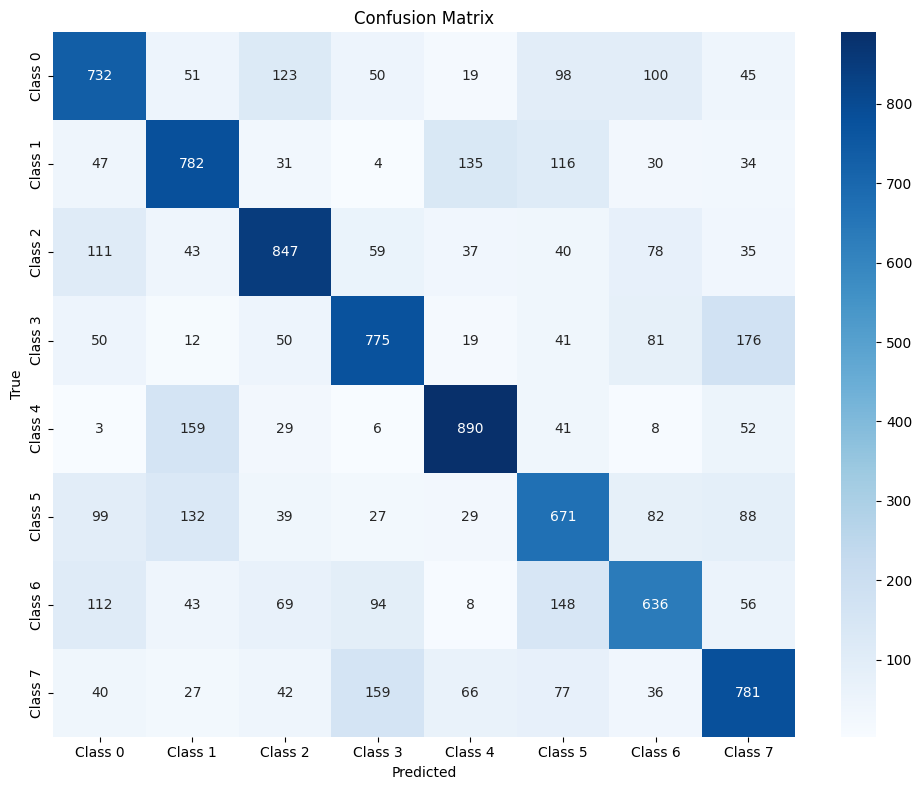

In [16]:
metris = model.evaluate(test_loader)

In [17]:
print(metris)

{'accuracy': 0.636875, 'classification_report': {'Class 0': {'precision': 0.6130653266331658, 'recall': 0.6009852216748769, 'f1-score': 0.6069651741293532, 'support': 1218.0}, 'Class 1': {'precision': 0.6261008807045636, 'recall': 0.6632739609838847, 'f1-score': 0.6441515650741351, 'support': 1179.0}, 'Class 2': {'precision': 0.6886178861788618, 'recall': 0.6776, 'f1-score': 0.6830645161290323, 'support': 1250.0}, 'Class 3': {'precision': 0.6601362862010222, 'recall': 0.643687707641196, 'f1-score': 0.6518082422203533, 'support': 1204.0}, 'Class 4': {'precision': 0.7398171238570241, 'recall': 0.7491582491582491, 'f1-score': 0.7444583856127144, 'support': 1188.0}, 'Class 5': {'precision': 0.5446428571428571, 'recall': 0.5749785775492716, 'f1-score': 0.5593997498957899, 'support': 1167.0}, 'Class 6': {'precision': 0.6051379638439581, 'recall': 0.5454545454545454, 'f1-score': 0.5737483085250338, 'support': 1166.0}, 'Class 7': {'precision': 0.6164167324388319, 'recall': 0.6359934853420195, 

<Figure size 1200x600 with 0 Axes>

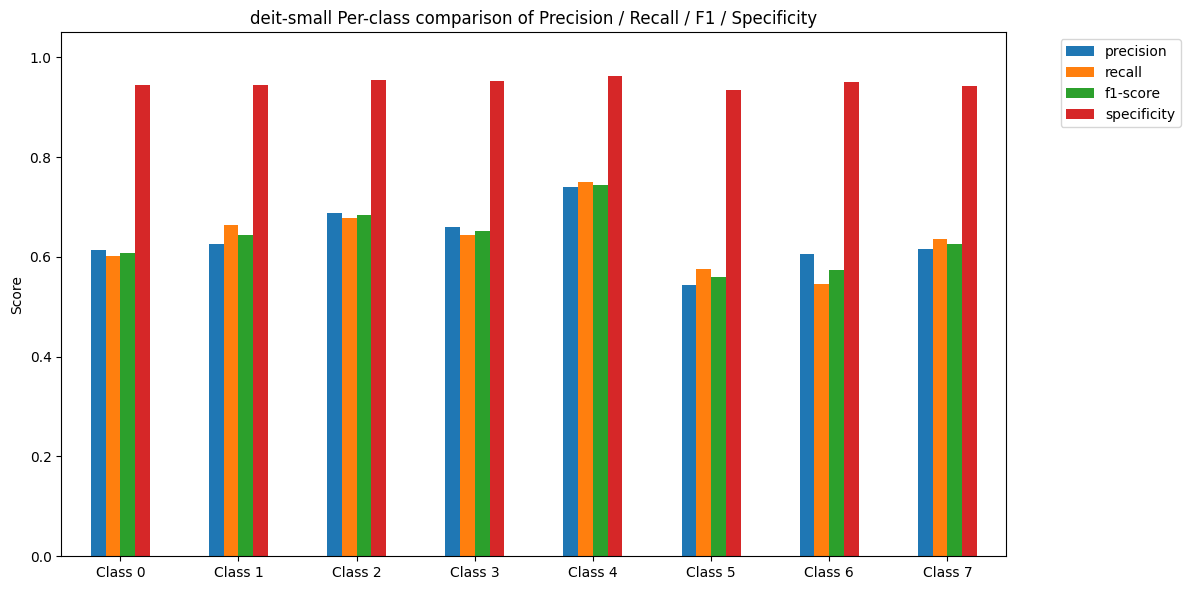

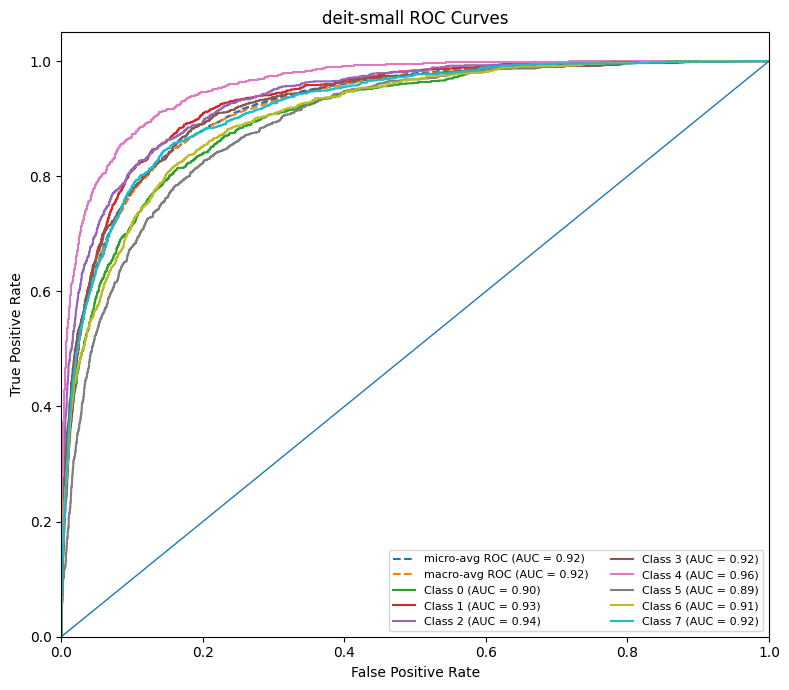

In [18]:
plot(metris, model, "deit-small")

<Figure size 1200x600 with 0 Axes>

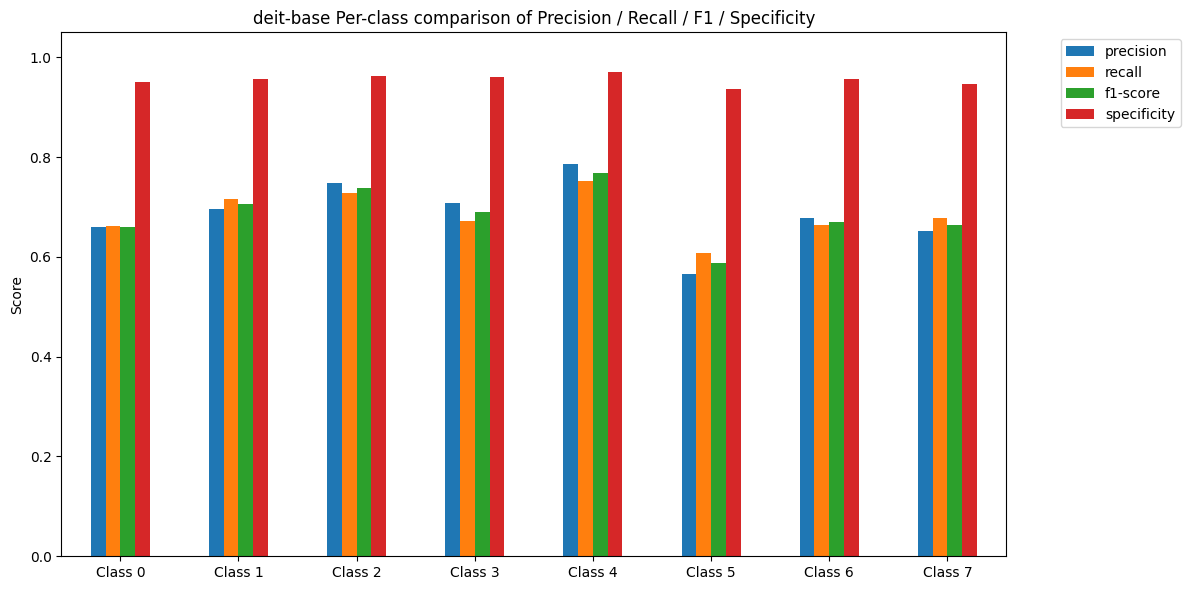

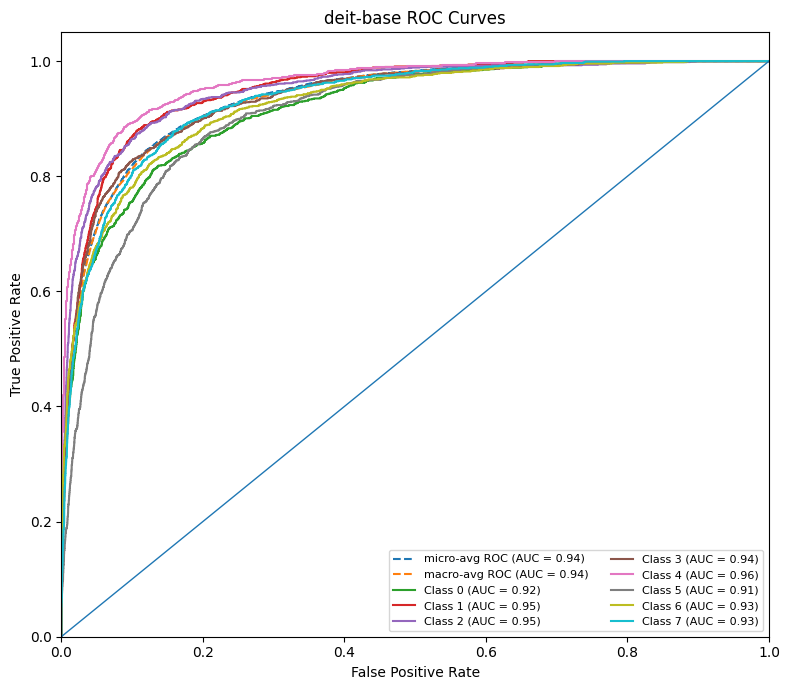

In [14]:
plot(metris, model, "deit-base")